### **Analyzing and Forecasting Traffic Patterns in California District 3 Using Hierarchical Time Series and Deep Learning**

## **Introduction**

Traffic congestion remains a critical challenge in urban mobility, influencing commute times, environmental sustainability, and overall transportation efficiency. This study leverages historical traffic data from **California’s District 3**, obtained from the **Caltrans Performance Measurement System (PeMS)**, to explore traffic trends and develop predictive models that enhance traffic management and forecasting.

## **Objectives**
The primary goal of this analysis is to **build a hierarchical time series model** to forecast traffic patterns and later incorporate **deep learning models** for enhanced predictive performance. This study follows a structured approach:

1. **Exploratory Data Analysis (EDA):**
   - Conduct a thorough statistical and visual analysis of the traffic data.
   - Identify seasonality, trends, and anomalies in the dataset.
   - Evaluate key traffic variables such as **total flow, average speed, and direction of travel**.

2. **Basic Time Series Modeling:**
   - Apply classical **time series models** such as **ARIMA, SARIMA, and Exponential Smoothing** to develop initial forecasting benchmarks.
   - Assess the performance of these models using standard evaluation metrics.

3. **Hierarchical Time Series Modeling:**
   - Construct **hierarchical time series (HTS) models** to analyze traffic patterns at different levels (e.g., station-level, route-level, and district-level).
   - Explore aggregation and disaggregation techniques for improved forecasting accuracy.

4. **Deep Learning Integration:**
   - Incorporate **deep learning-based forecasting models** such as **LSTMs and Transformer-based models** for more complex pattern recognition.
   - Compare model performance against traditional time series approaches.

5. **Incorporation of Electric Vehicle (EV) Charging Data:**
   - Integrate **EV charging station data** to analyze its impact on traffic congestion and patterns.
   - Develop a unified deep learning model that incorporates both **traffic and EV charging data** for holistic forecasting.

## **Data Source**
The traffic data used in this study is sourced from **PeMS (Caltrans Performance Measurement System)** and can be accessed at the following link:
[PeMS District 3 Traffic Data](https://pems.dot.ca.gov/?dnode=Clearinghouse&type=station_hour&district_id=3&submit=Submit)
The dataset contains **hourly traffic measurements** across multiple stations in District 3, capturing critical variables such as **total flow, speed, and observed percentages**.

## **Significance of the Study**
Accurate traffic forecasting is essential for **transportation planning, congestion mitigation, and infrastructure optimization**. By combining traditional time series techniques with **hierarchical modeling and deep learning**, this study aims to provide a **robust predictive framework** for traffic management in District 3 and beyond.

In [103]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

In [5]:
# Use a raw string (r"") to avoid path issues
folder_path = r"C:\Users\attafuro\Desktop\Traffic Analysis"  
output_file = os.path.join(folder_path, "merged_traffic_data.csv")

# Find all text files
file_paths = glob.glob(os.path.join(folder_path, "*.txt"))

# Open the output file and process each text file one by one
with open(output_file, "w") as output:
    first_file = True  # Track first file to write column headers

    for file in file_paths:
        print(f"Processing: {file}")

        # Read file in chunks to save memory
        for chunk in pd.read_csv(file, delimiter=",", chunksize=10000):  # Adjust delimiter if needed
            chunk.to_csv(output, index=False, header=first_file, mode="a")
            first_file = False  # After first file, don’t write headers again
        
        # Remove the processed file to free up space
        os.remove(file)
        print(f"Deleted: {file}")

print(f" Merge completed! CSV saved as '{output_file}'.")


Processing: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_06.txt
Deleted: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_06.txt
Processing: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_07.txt
Deleted: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_07.txt
Processing: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_08.txt
Deleted: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_08.txt
Processing: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_09.txt
Deleted: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_09.txt
Processing: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_10.txt
Deleted: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_10.txt
Processing: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_11.txt
Deleted: C:\Users\attafuro\Desktop\T

## Data Cleaning

In [24]:
# Load the merged file
df = pd.read_csv("C:/Users/attafuro/Desktop/Traffic Analysis/merged_traffic_data.csv")

# Display basic info
df.head()

,06/01/2024 00:00:00,308511,3,50,E,ML,3.134,216,100,39,...,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
0,06/01/2024 00:00:00,308512,3,50,W,ML,3.995,195,0,598.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06/01/2024 00:00:00,311831,3,5,S,OR,NaN,108,100,39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06/01/2024 00:00:00,311832,3,5,S,FR,NaN,108,100,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06/01/2024 00:00:00,311844,3,5,N,OR,NaN,216,100,107.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06/01/2024 00:00:00,311847,3,5,N,OR,NaN,324,100,101.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Define the correct column names
column_names = [
    "Timestamp", "Station", "District", "Route", "Direction of Travel", "Lane Type",
    "Station Length", "Samples", "% Observed", "Total Flow", "Avg Occupancy", "Avg Speed",
    "Delay (V_t=35)", "Delay (V_t=40)", "Delay (V_t=45)", "Delay (V_t=50)", "Delay (V_t=55)", "Delay (V_t=60)"
]

In [26]:
# Identify extra columns (Lane N data) and rename accordingly
num_extra_cols = len(df.columns) - len(column_names)
for i in range(1, num_extra_cols // 3 + 1):  
    column_names.extend([
        f"Lane {i} Flow", f"Lane {i} Avg Occ", f"Lane {i} Avg Speed"
    ])

# Apply new column names
df.columns = column_names

# Save the cleaned dataset
cleaned_file_path = "C:/Users/attafuro/Desktop/Traffic Analysis/cleaned_traffic_data.csv"
df.to_csv(cleaned_file_path, index=False)

print(f" Column names fixed! Cleaned data saved as '{cleaned_file_path}'.")

 Column names fixed! Cleaned data saved as 'C:/Users/attafuro/Desktop/Traffic Analysis/cleaned_traffic_data.csv'.


In [27]:
df = pd.read_csv(cleaned_file_path)
df.head()

,Timestamp,Station,District,Route,Direction of Travel,Lane Type,Station Length,Samples,% Observed,Total Flow,...,Lane 5 Avg Speed,Lane 6 Flow,Lane 6 Avg Occ,Lane 6 Avg Speed,Lane 7 Flow,Lane 7 Avg Occ,Lane 7 Avg Speed,Lane 8 Flow,Lane 8 Avg Occ,Lane 8 Avg Speed
0,06/01/2024 00:00:00,308512,3,50,W,ML,3.995,195,0,598.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06/01/2024 00:00:00,311831,3,5,S,OR,NaN,108,100,39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06/01/2024 00:00:00,311832,3,5,S,FR,NaN,108,100,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06/01/2024 00:00:00,311844,3,5,N,OR,NaN,216,100,107.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06/01/2024 00:00:00,311847,3,5,N,OR,NaN,324,100,101.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# Convert 'Timestamp' to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%m/%d/%Y %H:%M:%S")

# Define the final selected columns
selected_columns = [
    "Timestamp", "Station", "Route", "Direction of Travel",
    "Total Flow", "Avg Speed", "% Observed","Samples","Lane Type"
]

# Keep only the selected columns
df = df[selected_columns]

In [29]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,Avg Speed,% Observed,Samples,Lane Type
0,2024-06-01,308512,50,W,598.0,63.7,0,195,ML
1,2024-06-01,311831,5,S,39.0,NaN,100,108,OR
2,2024-06-01,311832,5,S,0.0,NaN,100,108,FR
3,2024-06-01,311844,5,N,107.0,NaN,100,216,OR
4,2024-06-01,311847,5,N,101.0,NaN,100,324,OR


In [30]:
# Display initial summary
print(" Initial Data Overview:")
print(df.info())  # Check data types

 Initial Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9495975 entries, 0 to 9495974
Data columns (total 9 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Timestamp            datetime64[ns]
 1   Station              int64         
 2   Route                int64         
 3   Direction of Travel  object        
 4   Total Flow           float64       
 5   Avg Speed            float64       
 6   % Observed           int64         
 7   Samples              int64         
 8   Lane Type            object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 652.0+ MB
None


In [22]:
print("\nMissing Values:\n", df.isnull().sum())  # Count missing values


Missing Values:
 Timestamp                    0
Station                      0
Route                        0
Direction of Travel          0
Total Flow              672053
Avg Speed              3603209
% Observed                   0
Samples                      0
Lane Type                    0
dtype: int64


In [32]:
# Fill Total Flow missing values with median of same Route & Lane Type
df['Total Flow'] = df.groupby(['Route', 'Lane Type'])['Total Flow'].transform(lambda x: x.fillna(x.median()))

In [33]:
# Set Avg Speed to 0 where Total Flow is 0
df.loc[df['Total Flow'] == 0, 'Avg Speed'] = 0

In [34]:
# Fill remaining missing Avg Speed values with median of similar Route & Lane Type
df['Avg Speed'] = df.groupby(['Route', 'Lane Type'])['Avg Speed'].transform(lambda x: x.fillna(x.median()))

In [35]:
print(" Missing Values After Cleaning:\n", df.isnull().sum())

 Missing Values After Cleaning:
 Timestamp                  0
Station                    0
Route                      0
Direction of Travel        0
Total Flow                 0
Avg Speed              33601
% Observed                 0
Samples                    0
Lane Type                  0
dtype: int64


In [37]:
# Fill any remaining missing values with the global median Avg Speed
df.loc[:, 'Avg Speed'] = df['Avg Speed'].fillna(df['Avg Speed'].median())

In [38]:
# Optimize numeric columns
df['Total Flow'] = df['Total Flow'].astype('int32')
df['Avg Speed'] = df['Avg Speed'].astype('int32')
df['% Observed'] = df['% Observed'].astype('int16')
df['Samples'] = df['Samples'].astype('int16')
df['Station'] = df['Station'].astype('int32')
df['Route'] = df['Route'].astype('int32')

# Convert categorical columns to category type
df['Direction of Travel'] = df['Direction of Travel'].astype('category')
df['Lane Type'] = df['Lane Type'].astype('category')

In [39]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,Avg Speed,% Observed,Samples,Lane Type
0,2024-06-01,308512,50,W,598,63,0,195,ML
1,2024-06-01,311831,5,S,39,0,100,108,OR
2,2024-06-01,311832,5,S,0,0,100,108,FR
3,2024-06-01,311844,5,N,107,0,100,216,OR
4,2024-06-01,311847,5,N,101,0,100,324,OR


In [40]:
# Extract time features from Timestamp
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Day_of_Week'] = df['Timestamp'].dt.weekday  # Monday = 0, Sunday = 6
df['Hour'] = df['Timestamp'].dt.hour  

# Check updated DataFrame
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,Avg Speed,% Observed,Samples,Lane Type,Year,Month,Day,Day_of_Week,Hour
0,2024-06-01,308512,50,W,598,63,0,195,ML,2024,6,1,5,0
1,2024-06-01,311831,5,S,39,0,100,108,OR,2024,6,1,5,0
2,2024-06-01,311832,5,S,0,0,100,108,FR,2024,6,1,5,0
3,2024-06-01,311844,5,N,107,0,100,216,OR,2024,6,1,5,0
4,2024-06-01,311847,5,N,101,0,100,324,OR,2024,6,1,5,0


In [41]:
df.loc[:, df.columns != 'Timestamp'] #drop the timstamp column

,Station,Route,Direction of Travel,Total Flow,Avg Speed,% Observed,Samples,Lane Type,Year,Month,Day,Day_of_Week,Hour
0,308512,50,W,598,63,0,195,ML,2024,6,1,5,0
1,311831,5,S,39,0,100,108,OR,2024,6,1,5,0
2,311832,5,S,0,0,100,108,FR,2024,6,1,5,0
3,311844,5,N,107,0,100,216,OR,2024,6,1,5,0
4,311847,5,N,101,0,100,324,OR,2024,6,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9495970,3423094,99,S,68,64,96,118,ML,2024,12,31,1,23
9495971,3900021,50,E,803,66,67,292,ML,2024,12,31,1,23
9495972,3900022,50,E,509,68,0,0,HV,2024,12,31,1,23
9495973,3900023,50,W,881,67,67,289,ML,2024,12,31,1,23


## Exploratory Data Analysis

In [45]:
# Summary of numerical columns
df.describe()

,Timestamp,Station,Route,Total Flow,Avg Speed,% Observed,Samples,Year,Month,Day,Day_of_Week,Hour
count,9495975,9.495975e+06,9.495975e+06,9.495975e+06,9.495975e+06,9.495975e+06,9.495975e+06,9495975.0,9.495975e+06,9.495975e+06,9.495975e+06,9.495975e+06
mean,2024-09-16 09:07:39.713931520,1.539897e+06,6.455738e+01,9.643129e+02,3.930087e+01,7.939264e+01,1.877938e+02,2024.0,9.017659e+00,1.579375e+01,2.998893e+00,1.150007e+01
min,2024-06-01 00:00:00,3.085110e+05,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2024.0,6.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2024-07-25 00:00:00,3.160010e+05,5.000000e+01,9.500000e+01,0.000000e+00,9.200000e+01,1.030000e+02,2024.0,7.000000e+00,8.000000e+00,1.000000e+00,6.000000e+00
50%,2024-09-16 16:00:00,3.192950e+05,6.500000e+01,4.210000e+02,6.200000e+01,1.000000e+02,1.200000e+02,2024.0,9.000000e+00,1.600000e+01,3.000000e+00,1.200000e+01
75%,2024-11-08 19:00:00,3.047122e+06,8.000000e+01,1.245000e+03,6.500000e+01,1.000000e+02,2.400000e+02,2024.0,1.100000e+01,2.300000e+01,5.000000e+00,1.800000e+01
max,2024-12-31 23:00:00,3.900024e+06,5.050000e+02,1.150600e+04,9.900000e+01,1.000000e+02,1.128000e+03,2024.0,1.200000e+01,3.100000e+01,6.000000e+00,2.300000e+01
std,NaN,1.400130e+06,4.185411e+01,1.308506e+03,3.134621e+01,3.804620e+01,1.292097e+02,0.0,1.997460e+00,8.823053e+00,2.011526e+00,6.922230e+00


In [46]:
# Summary of categorical columns
print("\nCategorical Value Counts:")
print(df[['Direction of Travel', 'Lane Type']].value_counts())


Categorical Value Counts:
Direction of Travel  Lane Type
E                    ML           1258187
W                    ML           1222223
S                    ML           1024964
N                    ML            981681
E                    OR            562479
S                    OR            524473
W                    OR            522779
N                    OR            521387
W                    HV            479642
E                    HV            477987
W                    FR            357548
E                    FR            333865
N                    FR            329329
S                    FR            307541
N                    HV            235489
S                    HV            212593
                     FF             51360
E                    FF             41088
N                    FF             35952
W                    FF             15408
Name: count, dtype: int64


In [63]:
# Set Seaborn theme for consistent styling
sns.set_theme(style="whitegrid")

# Define colorblind-friendly palettes
palette_numerical = sns.color_palette("viridis", 4)  # 4 distinct colors for numerical features
palette_categorical = sns.color_palette("Set2", 2)   # 2 distinct colors for categorical features

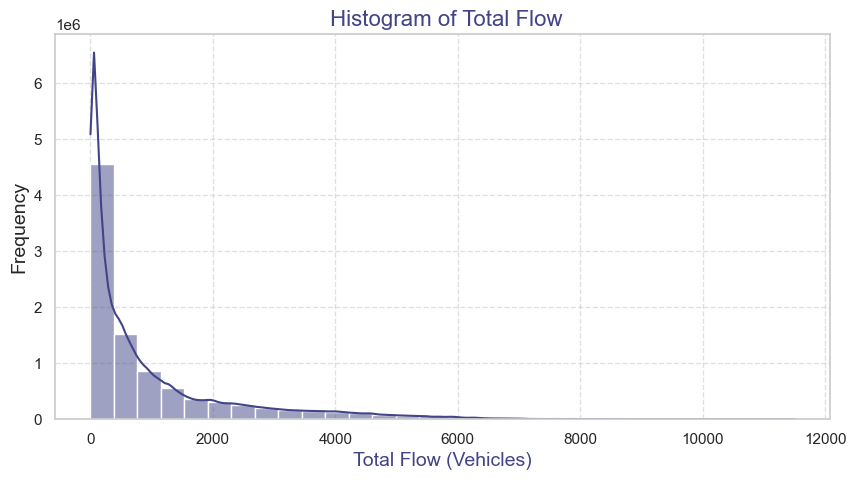

In [64]:
plt.figure(figsize=(10,5))
sns.histplot(df['Total Flow'], bins=30, kde=True, color=palette_numerical[0])
plt.title(" Histogram of Total Flow", fontsize=16, color=palette_numerical[0])
plt.xlabel("Total Flow (Vehicles)", fontsize=14, color=palette_numerical[0])
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
The distribution of Total Flow (vehicles) is highly right-skewed.
Most traffic observations have a low vehicle count, but there are some high-flow observations.
The long tail suggests there are a few locations or time periods with exceptionally high traffic volumes.
The majority of traffic stations record low traffic volumes.
High-flow locations might represent major highways or peak rush-hour times.

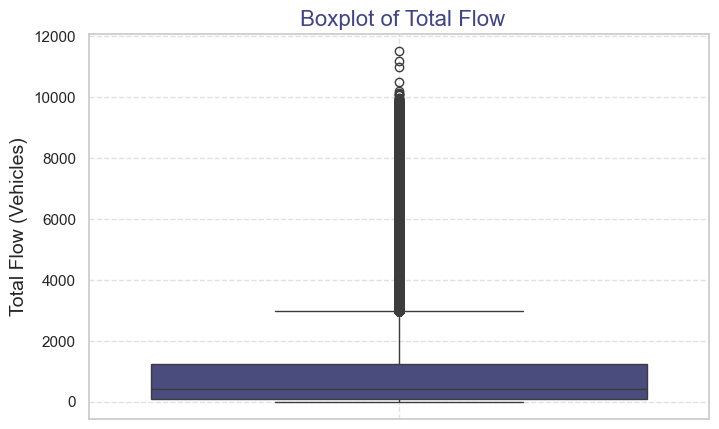

In [65]:
plt.figure(figsize=(8,5))
sns.boxplot(y=df['Total Flow'], color=palette_numerical[0])
plt.title(" Boxplot of Total Flow", fontsize=16, color=palette_numerical[0])
plt.ylabel("Total Flow (Vehicles)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
There are many outliers in Total Flow, visible as points above the whiskers.
The median flow is relatively low, with most observations below 2000 vehicles.
Some stations experience very high congestion levels, causing extreme values.
There is high variability in traffic flow across different stations.
The presence of outliers suggests that a few locations experience extremely high congestion.
Further analysis is required to determine whether outliers are anomalies or genuine high-traffic locations.

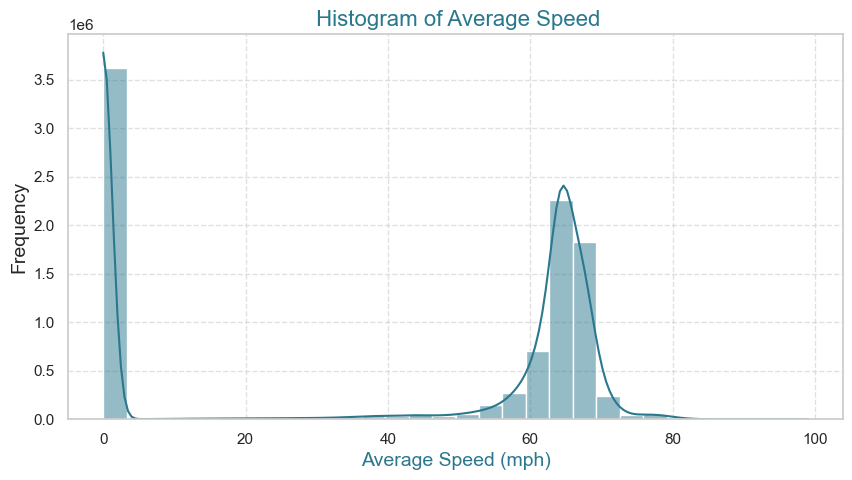

In [68]:
plt.figure(figsize=(10,5))
sns.histplot(df['Avg Speed'], bins=30, kde=True, color=palette_numerical[1])
plt.title(" Histogram of Average Speed", fontsize=16, color=palette_numerical[1])
plt.xlabel("Average Speed (mph)", fontsize=14, color=palette_numerical[1])
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Interpretation:
Two distinct peaks suggest a bimodal distribution:
One peak at 0-10 mph, possibly representing heavy congestion.
Another peak around 60-70 mph, indicating free-flowing traffic.
The speed data suggests different traffic conditions at different times.
The first peak (near 0 mph) represents locations or times when traffic is heavily congested.
The second peak (65 mph) represents areas with smooth traffic flow.
The mix of slow and fast speeds indicates high variability in traffic conditions.

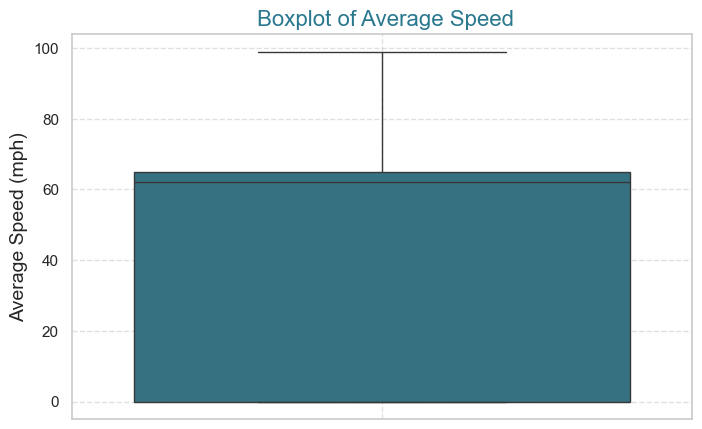

In [69]:
plt.figure(figsize=(8,5))
sns.boxplot(y=df['Avg Speed'], color=palette_numerical[1])
plt.title(" Boxplot of Average Speed", fontsize=16, color=palette_numerical[1])
plt.ylabel("Average Speed (mph)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
The interquartile range (IQR) is wide, meaning there is significant speed variation across stations.
The whiskers extend to the maximum speed (100 mph), but most observations are below 70 mph.
The lower bound suggests some vehicles are moving extremely slowly or are in congested conditions.
A significant portion of the data represents traffic moving at low speeds.
The large range of speeds suggests multiple traffic scenarios (e.g., urban congestion vs. freeway travel).
Further analysis could focus on identifying patterns in slow-moving vs. fast-moving traffic.

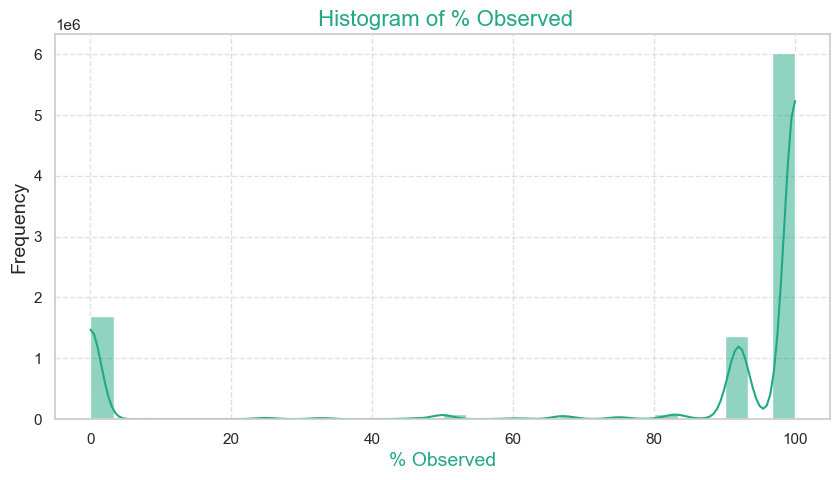

In [70]:
plt.figure(figsize=(10,5))
sns.histplot(df['% Observed'], bins=30, kde=True, color=palette_numerical[2])
plt.title(" Histogram of % Observed", fontsize=16, color=palette_numerical[2])
plt.xlabel("% Observed", fontsize=14, color=palette_numerical[2])
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

The majority of data points are clustered around 100% or 0%, indicating that:
Some sensors consistently report data fully (100%).
Some sensors are not reporting any data (0%).
This suggests issues related to data collection and sensor coverage.
High % Observed values (near 100%) indicate well-functioning sensors.
Low % Observed values (near 0%) might indicate:
Broken sensors.
Temporary disruptions in data collection.
Unmonitored locations.

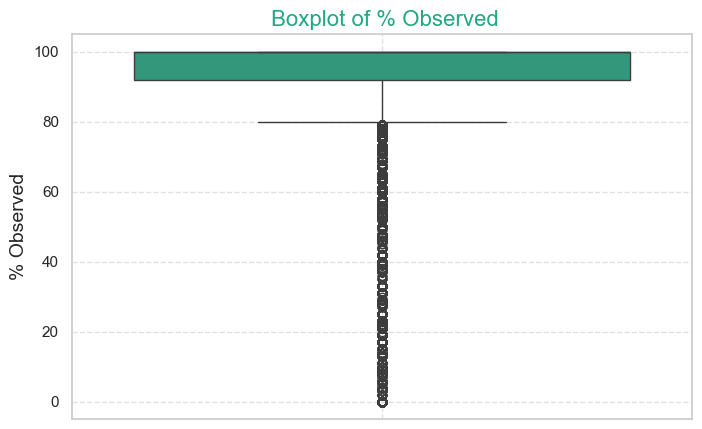

In [71]:
plt.figure(figsize=(8,5))
sns.boxplot(y=df['% Observed'], color=palette_numerical[2])
plt.title(" Boxplot of % Observed", fontsize=16, color=palette_numerical[2])
plt.ylabel("% Observed", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
A large number of outliers below 80% suggests significant data loss.
The median is close to 100%, meaning most sensors work well.
The lower whisker extends to 0%, confirming some sensors fail to capture data.

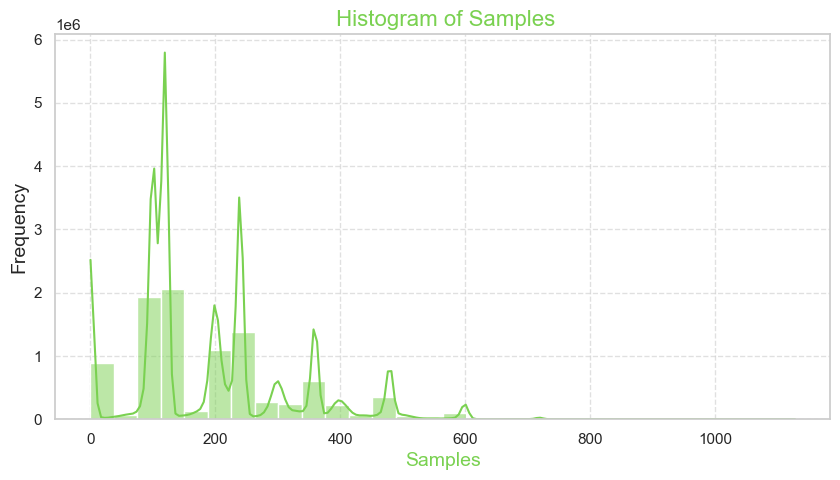

In [122]:
plt.figure(figsize=(10,5))
sns.histplot(df['Samples'], bins=30, kde=True, color=palette_numerical[3])
plt.title(" Histogram of Samples", fontsize=16, color=palette_numerical[3])
plt.xlabel("Samples", fontsize=14, color=palette_numerical[3])
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

The distribution of the number of samples collected is multimodal.
Peaks at specific intervals (e.g., 200, 400, 600) suggest standardized data collection rates.
The spikes in frequency suggest traffic sensors operate in predefined sampling intervals.

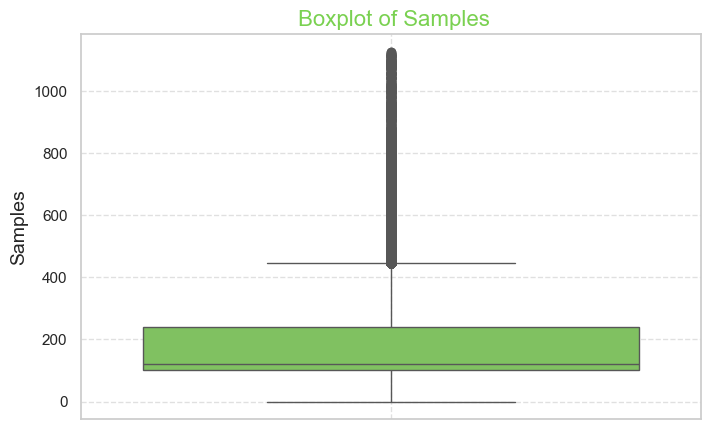

In [73]:
plt.figure(figsize=(8,5))
sns.boxplot(y=df['Samples'], color=palette_numerical[3])
plt.title(" Boxplot of Samples", fontsize=16, color=palette_numerical[3])
plt.ylabel("Samples", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Many outliers appear above 600 samples, indicating some stations collect significantly more data than others.
The IQR is relatively small, meaning most stations have a similar number of samples.
Some stations record very few samples, possibly due to malfunctioning or underutilized sensors.
Stations with very high sample counts may be on highways or critical intersections.

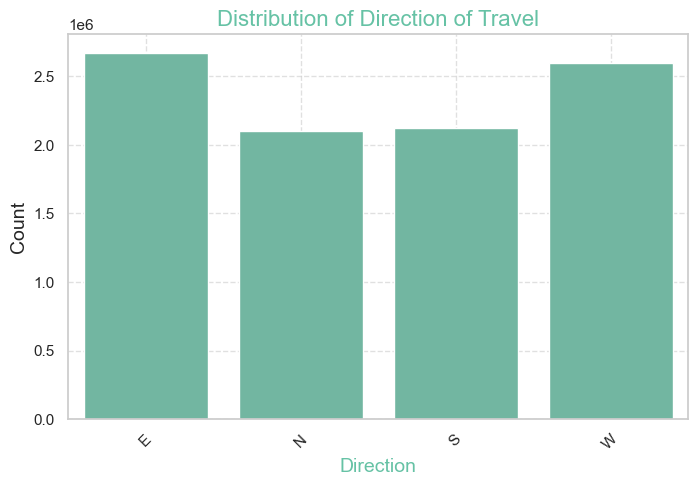

In [74]:
plt.figure(figsize=(8,5))
sns.countplot(x=df['Direction of Travel'], color=palette_categorical[0])
plt.title("Distribution of Direction of Travel", fontsize=16, color=palette_categorical[0])
plt.xlabel("Direction", fontsize=14, color=palette_categorical[0])
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
The distribution of traffic movement directions is fairly balanced.
The East (E) and West (W) directions have slightly higher counts than North (N) and South (S).
The higher frequency of East-West travel may indicate major highways running in those directions.

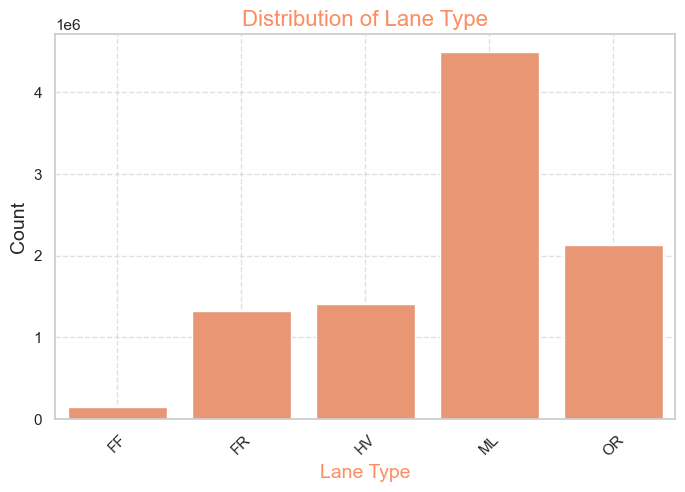

In [75]:
plt.figure(figsize=(8,5))
sns.countplot(x=df['Lane Type'], color=palette_categorical[1])
plt.title("Distribution of Lane Type", fontsize=16, color=palette_categorical[1])
plt.xlabel("Lane Type", fontsize=14, color=palette_categorical[1])
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
ML (Mainline) lanes are the most common, followed by OR (On Ramp), FR (Off Ramp), and HV (High-Occupancy Vehicles).
FF (Freeway-Freeway connectors) are the least common, which makes sense as they are limited to interchanges.
The dominance of Mainline lanes suggests most data is from major roads rather than ramps or special-use lanes.
The distribution of lane types can impact congestion patterns.

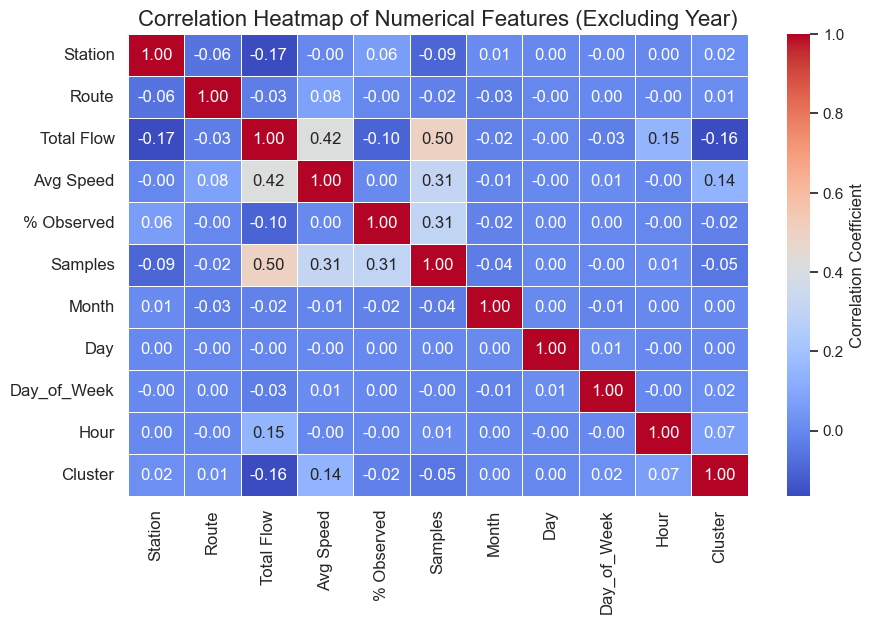

In [97]:
# Select only numerical columns but exclude 'Year'
numeric_df = df.select_dtypes(include=['number']).drop(columns=['Year'], errors='ignore')

plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Heatmap of Numerical Features (Excluding Year)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


The correlation coefficients range from -1 (strong negative) to 1 (strong positive).
Key Observations:
Total Flow and Avg Speed (0.42) → Moderate positive correlation, indicating that as traffic volume increases, speed tends to decrease.
Total Flow and Samples (0.50) → Moderate positive correlation, meaning locations with higher flow also tend to have more data samples.
Hour and Total Flow (0.15) → Weak positive correlation, suggesting a slight increase in flow at specific times of the day.
Cluster values show weak correlations, implying that the clustering process doesn't strongly align with any single feature.
Insights:
The negative correlation between Flow and Speed confirms that higher congestion slows down traffic.
The low correlation between Total Flow and % Observed (-0.10) suggests that missing data does not significantly impact flow measurement.

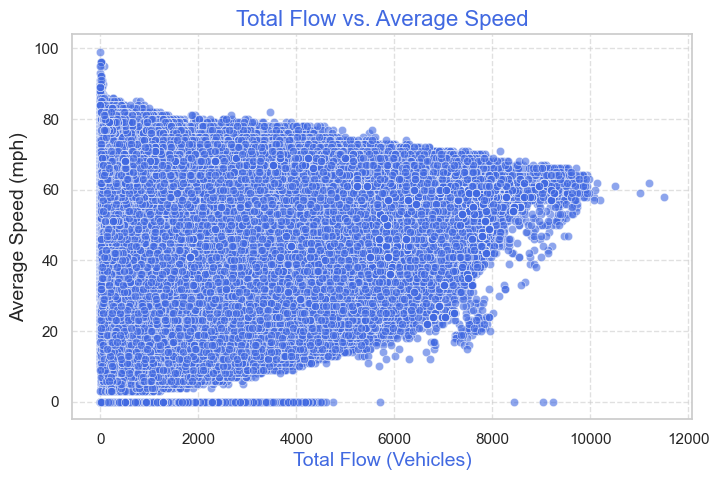

In [87]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['Total Flow'], y=df['Avg Speed'], alpha=0.6, color='royalblue')
plt.title("Total Flow vs. Average Speed", fontsize=16, color='royalblue')
plt.xlabel("Total Flow (Vehicles)", fontsize=14, color='royalblue')
plt.ylabel("Average Speed (mph)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
Negative trend implies Higher Total Flow is associated with lower Average Speed, confirming congestion effects.
Dense lower-left region thus, many observations have low flow and low speed, possibly representing congested city roads or peak traffic times.
Upper range (10,000 vehicles, 60-80 mph) → Represents high-speed highway conditions with smooth traffic.
This plot visually supports the negative correlation from the heatmap.
Speed dramatically decreases at high flow levels, suggesting potential bottlenecks or highway capacity issues.
Further segmentation by time of day could reveal rush-hour effects.

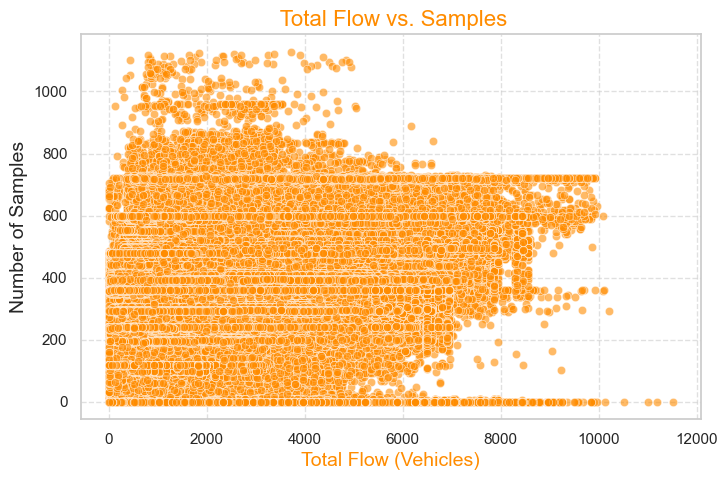

In [123]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['Total Flow'], y=df['Samples'], alpha=0.6, color='darkorange')
plt.title(" Total Flow vs. Samples", fontsize=16, color='darkorange')
plt.xlabel("Total Flow (Vehicles)", fontsize=14, color='darkorange')
plt.ylabel("Number of Samples", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
Strong positive trend implies more samples correspond to higher total flow.
Some stations record very few samples, even at high flow values.
Data distribution is more uniform across flow levels, with a few outliers.
Stations with low sample counts may not accurately reflect traffic conditions.
Ensuring sufficient samples per station is crucial for reliable modeling.
Potential next step: Investigate whether certain road types or time periods have more missing samples.

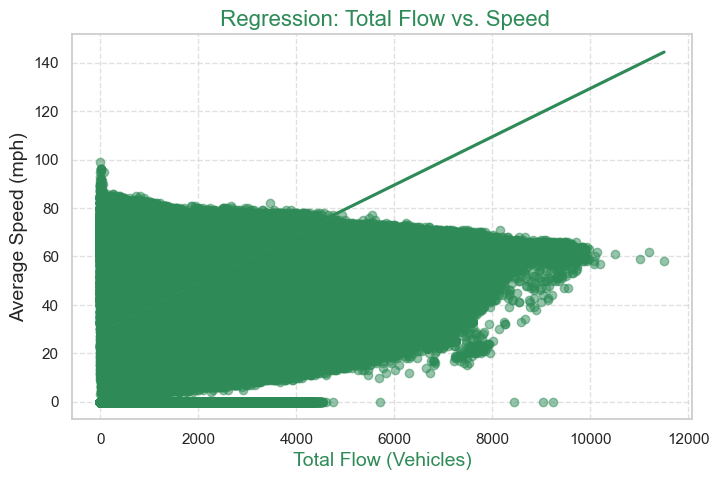

In [89]:
plt.figure(figsize=(8,5))
sns.regplot(x=df['Total Flow'], y=df['Avg Speed'], scatter_kws={'alpha':0.5}, color='seagreen')
plt.title(" Regression: Total Flow vs. Speed", fontsize=16, color='seagreen')
plt.xlabel("Total Flow (Vehicles)", fontsize=14, color='seagreen')
plt.ylabel("Average Speed (mph)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
The regression line unexpectedly trends upward at high flow values, likely influenced by outliers.
The expected inverse relationship (higher flow → lower speed) is visible in the denser lower-left region.
The top-right extreme points may not follow real-world traffic behavior and require investigation.
Some data points (high flow, high speed) could represent inaccurate sensor readings or low-density highway conditions.

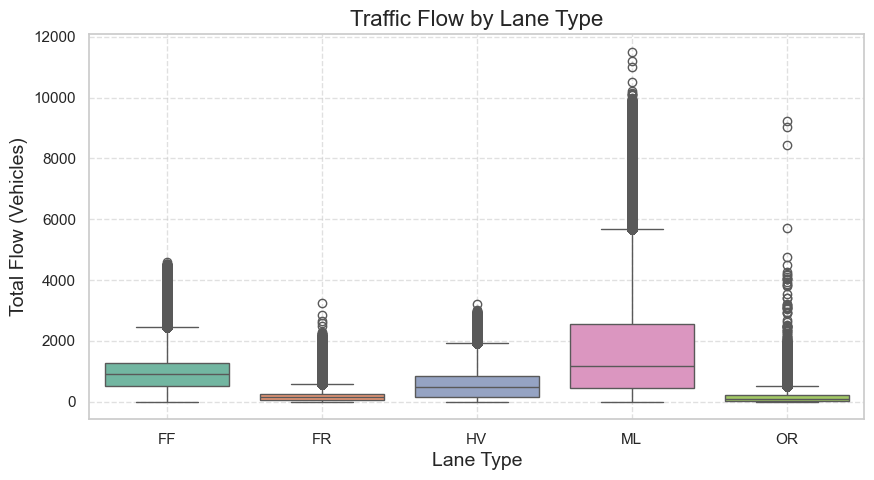

In [108]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df['Lane Type'], y=df['Total Flow'], hue=df['Lane Type'], palette="Set2")
plt.title("Traffic Flow by Lane Type", fontsize=16)
plt.xlabel("Lane Type", fontsize=14)
plt.ylabel("Total Flow (Vehicles)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
ML (Mainline) lanes have the highest median traffic flow, with significant outliers.
FF (Freeway-Freeway connectors) & HV (High Occupancy Vehicles) have much lower total flow.
High variability in OR (On Ramp) and FR (Off Ramp) lanes, indicating irregular traffic patterns.
Mainline lanes are the primary contributors to congestion.
On-ramps and off-ramps show extreme variations, likely due to different times of day and merging behavior.
A closer look at lane-specific congestion trends could improve forecasting models.

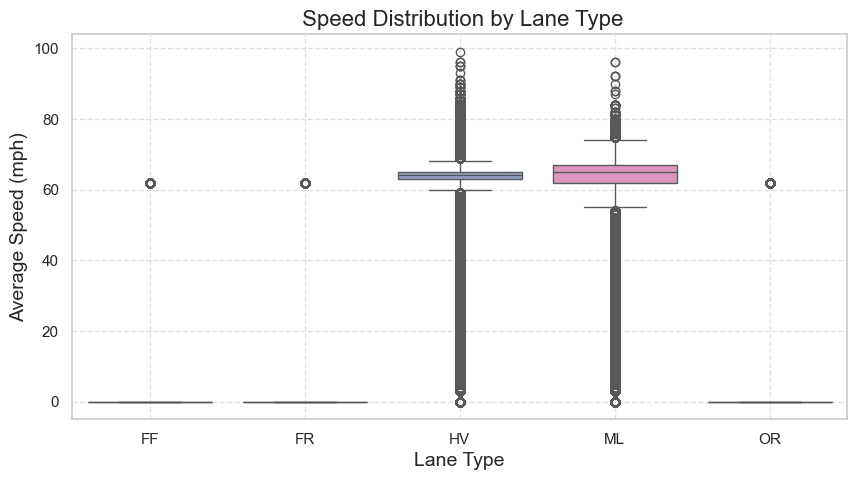

In [109]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df['Lane Type'], y=df['Avg Speed'], hue=df['Lane Type'], palette="Set2")
plt.title(" Speed Distribution by Lane Type", fontsize=16)
plt.xlabel("Lane Type", fontsize=14)
plt.ylabel("Average Speed (mph)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
ML (Mainline) and HV (HOV) lanes have the highest median speeds, suggesting smoother travel conditions.
FF (Freeway-Freeway connectors) have a wide range of speeds, likely due to merging effects.
Some lanes show speeds close to 0, indicating stop-and-go conditions or sensor inaccuracies.
HOV lanes generally perform well, reinforcing their effectiveness.
Low-speed outliers in ML and HV lanes may indicate congestion or incidents.
Further analysis could examine speed trends over time.

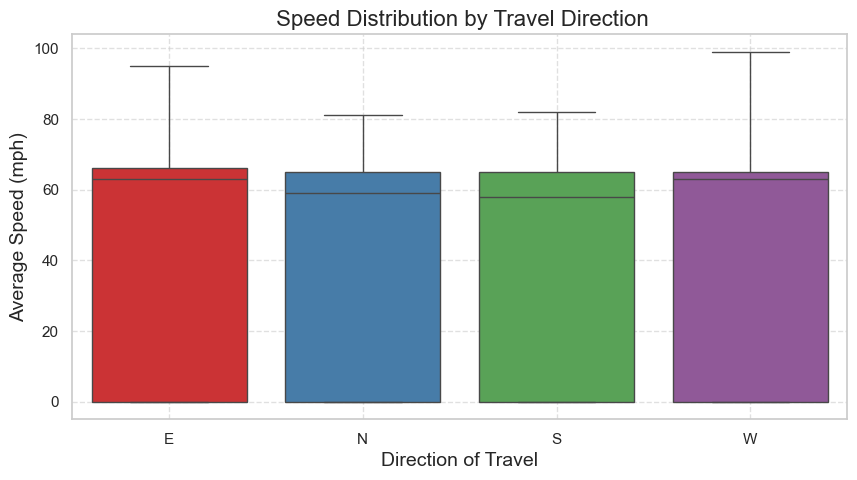

In [110]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df['Direction of Travel'], y=df['Avg Speed'], hue=df['Direction of Travel'], palette="Set1")
plt.title(" Speed Distribution by Travel Direction", fontsize=16)
plt.xlabel("Direction of Travel", fontsize=14)
plt.ylabel("Average Speed (mph)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
Speed distribution is relatively consistent across East, West, North, and South.
Westbound (W) travel has slightly higher max speeds, possibly due to highway design.
The presence of low-speed outliers across all directions suggests that traffic slowdowns occur in all directions.
Further exploration is needed to determine if time of day influences these distributions.
If speed patterns are similar across directions, location-specific factors may be more important than directionality.

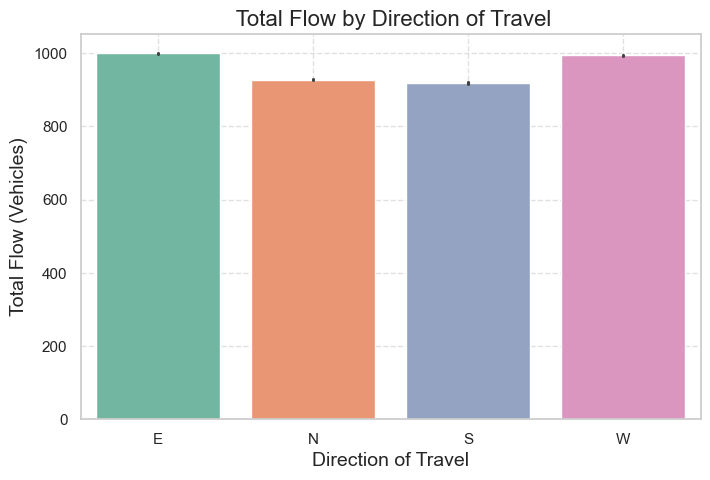

In [113]:
plt.figure(figsize=(8,5))
sns.barplot(x=df['Direction of Travel'], y=df['Total Flow'], hue=df['Direction of Travel'], palette="Set2")
plt.title(" Total Flow by Direction of Travel", fontsize=16)
plt.xlabel("Direction of Travel", fontsize=14)
plt.ylabel("Total Flow (Vehicles)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
Eastbound (E) and Westbound (W) lanes have the highest total flow, suggesting they are primary commuter routes.
Northbound (N) and Southbound (S) lanes have slightly lower flow, possibly due to urban road layouts.
If highway corridors are mostly E-W, infrastructure planning should focus on these routes.
North-South flow could be impacted by intersection delays or fewer major roads.

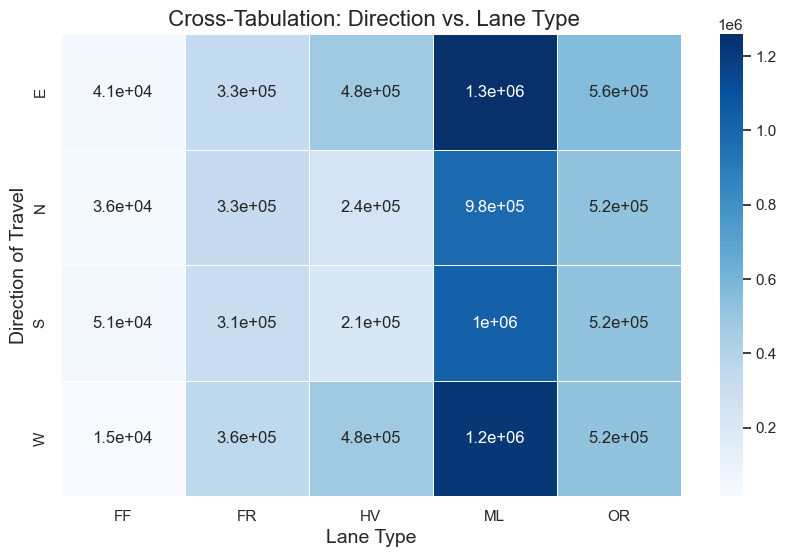

In [77]:
# Compute crosstab
direction_lane_crosstab = pd.crosstab(df['Direction of Travel'], df['Lane Type'])

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(direction_lane_crosstab, annot=True, cmap="Blues", linewidths=0.5)
plt.title(" Cross-Tabulation: Direction vs. Lane Type", fontsize=16)
plt.xlabel("Lane Type", fontsize=14)
plt.ylabel("Direction of Travel", fontsize=14)
plt.show()

Interpretation:
Mainline (ML) lanes dominate in all directions, with the highest traffic volume.
HOV lanes have relatively lower use, even on busy roads, which may indicate underutilization.
On-ramps (OR) and Off-ramps (FR) have significant flow in all directions, reinforcing their role in entry/exit.
HOV lane optimization could improve traffic efficiency.

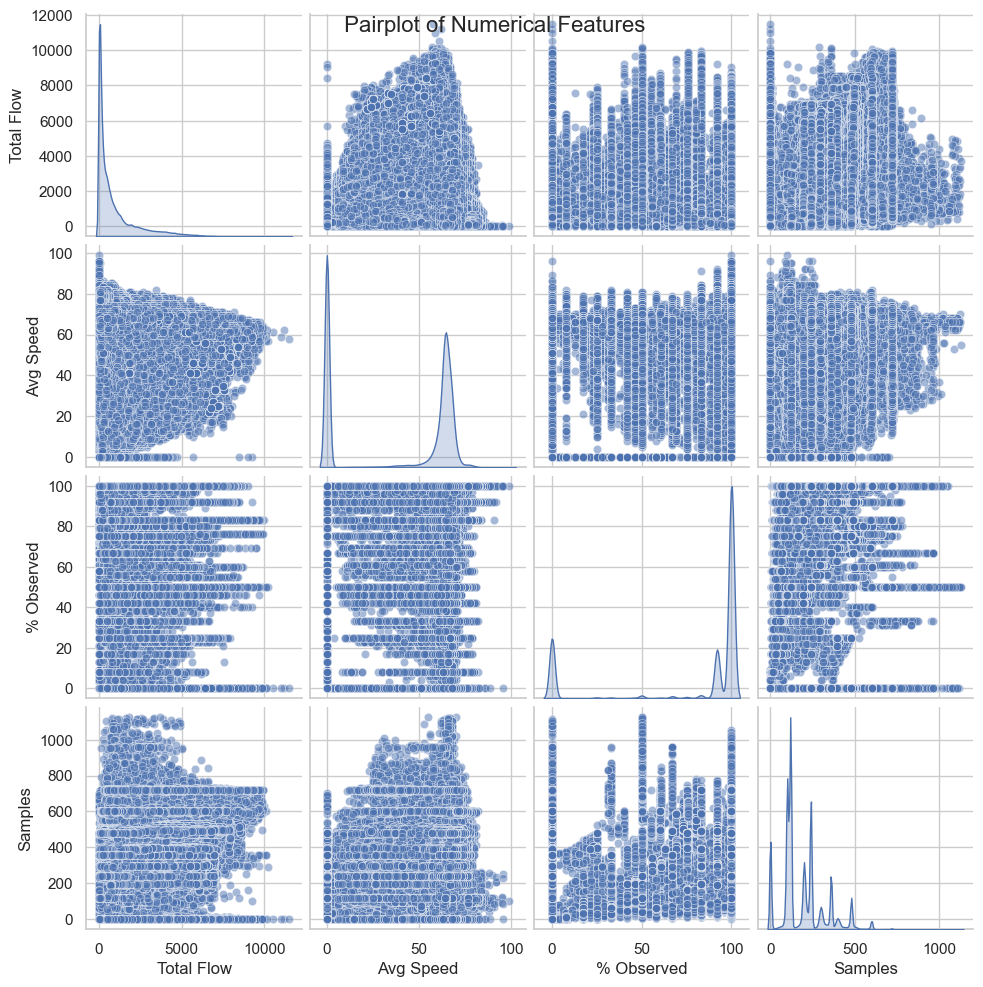

In [91]:
# Select numerical columns for pairplot
numerical_cols = ['Total Flow', 'Avg Speed', '% Observed', 'Samples']

sns.pairplot(df[numerical_cols], diag_kind="kde", plot_kws={"alpha":0.5})
plt.suptitle(" Pairplot of Numerical Features", fontsize=16)
plt.show()

Interpretation:
Clear negative relationship between Flow and Speed.
Bimodal distributions in % Observed suggest data reliability concerns.
Samples appear to be evenly distributed across different features.
The patterns confirm congestion effects, reinforcing the need for predictive modeling.
Some features may require transformation (log scaling) for better model performance.

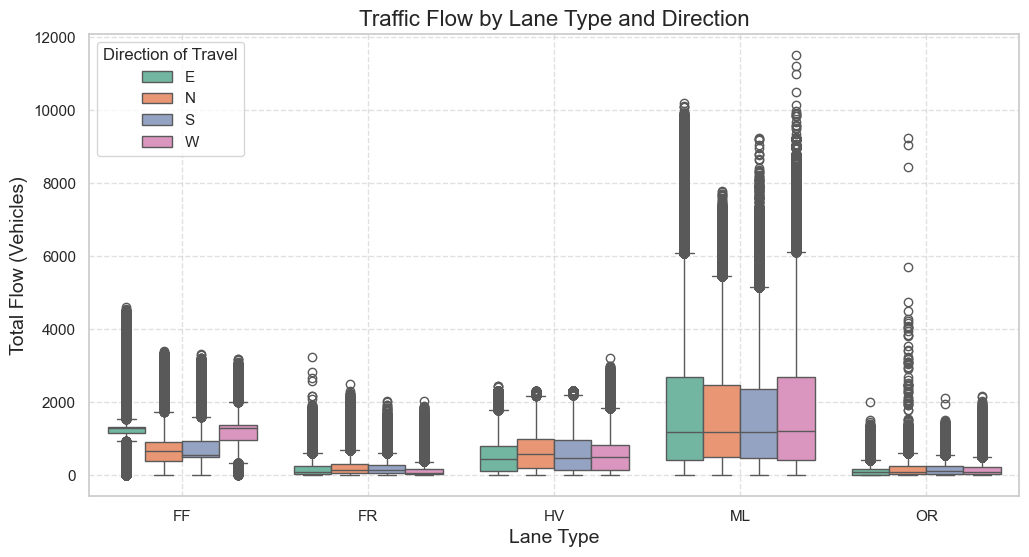

In [92]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['Lane Type'], y=df['Total Flow'], hue=df['Direction of Travel'], palette="Set2")
plt.title("Traffic Flow by Lane Type and Direction", fontsize=16)
plt.xlabel("Lane Type", fontsize=14)
plt.ylabel("Total Flow (Vehicles)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Direction of Travel")
plt.show()

Interpretation:
Mainline (ML) lanes have the highest traffic flow, across all directions.
Freeway-Freeway connectors (FF) and High-Occupancy Vehicle (HOV) lanes have lower traffic volumes.
On-ramps (OR) and Off-ramps (FR) have lower median flow but exhibit many outliers.
Traffic distribution is fairly consistent across directions (E, N, S, W).
Mainline lanes are the primary sources of congestion.
On-ramps and Off-ramps show a wide range of traffic conditions, likely due to varying merging and exiting behaviors.

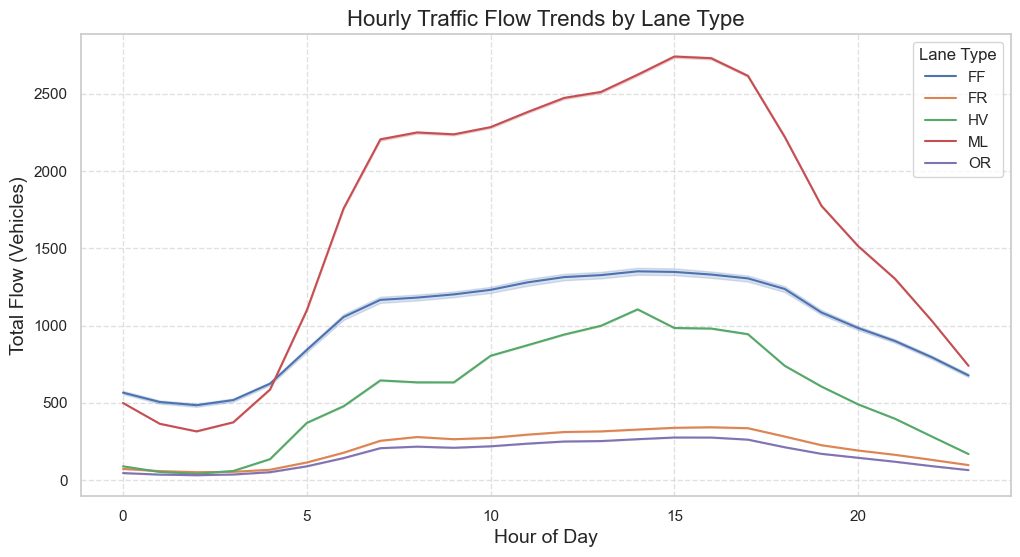

In [114]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df['Hour'], y=df['Total Flow'], hue=df['Lane Type'])
plt.title("Hourly Traffic Flow Trends by Lane Type", fontsize=16)
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Total Flow (Vehicles)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
Morning peak (6 AM - 9 AM) and evening peak (3 PM - 6 PM) are clearly visible.
Mainline (ML) lanes experience the highest congestion, while on/off ramps see lower but steady flow.
HOV lanes show a steady increase and peak in the afternoon.
Rush hour effects are significant and should be modeled in time-series forecasting.
HOV lanes increase during peak hours, suggesting effective usage by commuters.

In [100]:
df.columns = df.columns.str.strip()

In [101]:
# Selecting relevant features for clustering
X = df[['Total Flow', 'Avg Speed']].dropna()

# Convert to numeric 
X = X.apply(pd.to_numeric, errors='coerce')

# Run KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X)

print(df['Cluster'].value_counts())  # Verify cluster assignments


Cluster
1    6894357
2    1810324
0     791294
Name: count, dtype: int64


In [118]:
# Suppress legend performance warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="IPython.core.pylabtools")

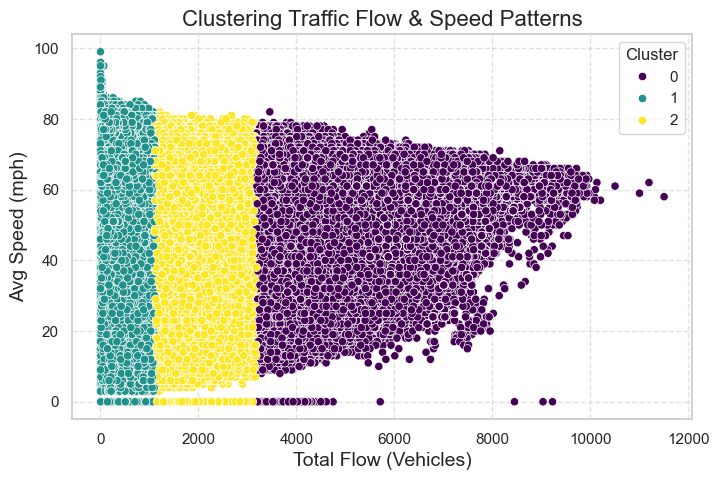

In [119]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['Total Flow'].astype(float), y=df['Avg Speed'].astype(float), hue=df['Cluster'], palette='viridis')
plt.title("Clustering Traffic Flow & Speed Patterns", fontsize=16)
plt.xlabel("Total Flow (Vehicles)", fontsize=14)
plt.ylabel("Avg Speed (mph)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Interpretation:
Three distinct clusters are identified:
Cluster 0 (Purple): High flow, low speed → Likely congested highways.
Cluster 1 (Green): Low flow, varying speed → Could be minor roads or off-peak traffic.
Cluster 2 (Yellow): Moderate flow, moderate speed → Normal operational roads.
Traffic conditions can be grouped into meaningful categories.
High-traffic, low-speed regions require congestion management strategies.

<Figure size 1000x500 with 0 Axes>

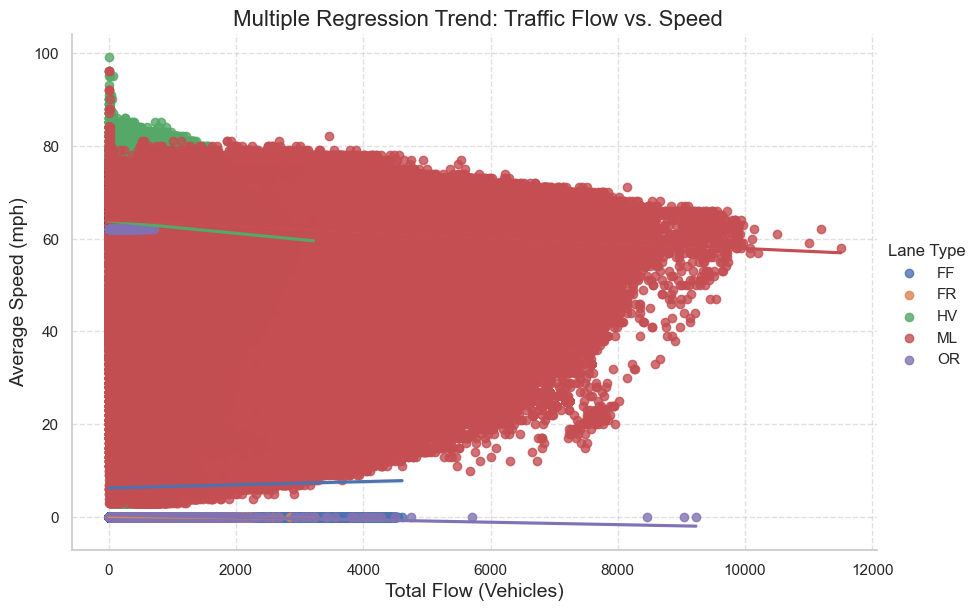

In [98]:
plt.figure(figsize=(10,5))
sns.lmplot(x='Total Flow', y='Avg Speed', hue='Lane Type', data=df, height=6, aspect=1.5)
plt.title(" Multiple Regression Trend: Traffic Flow vs. Speed", fontsize=16)
plt.xlabel("Total Flow (Vehicles)", fontsize=14)
plt.ylabel("Average Speed (mph)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Interpretation:
Mainline lanes dominate the traffic dataset, as shown by the red points.
As flow increases, speed generally decreases, confirming congestion effects.
HOV lanes show slightly higher speeds at similar traffic volumes.
Regression confirms negative speed-flow relationship.
Certain lane types (HOV) perform better than others, highlighting potential traffic management strategies.

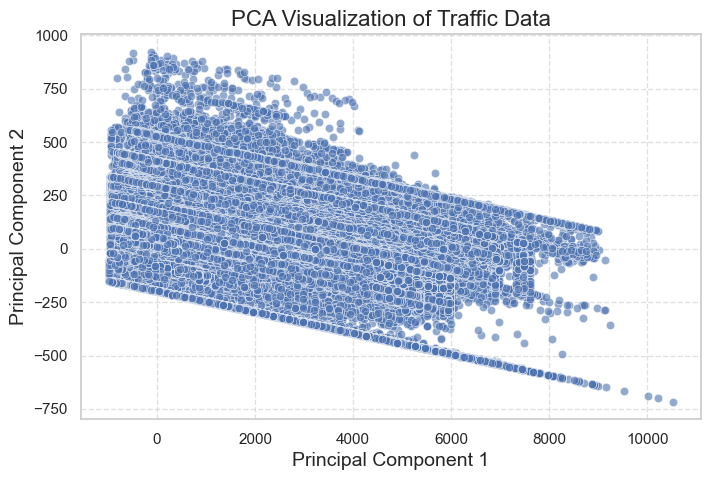

In [104]:
# Selecting numerical columns for PCA
X_pca = df[['Total Flow', 'Avg Speed', '% Observed', 'Samples']].dropna()

# Applying PCA
pca = PCA(n_components=2)
X_pca_transformed = pca.fit_transform(X_pca)

# Convert to DataFrame
df_pca = pd.DataFrame(X_pca_transformed, columns=["PC1", "PC2"])

plt.figure(figsize=(8,5))
sns.scatterplot(x=df_pca["PC1"], y=df_pca["PC2"], alpha=0.6)
plt.title("PCA Visualization of Traffic Data", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=14)
plt.ylabel("Principal Component 2", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Interpretation:
The first two Principal Components (PCs) explain the majority of variance in the dataset.
Data follows a downward diagonal trend, suggesting strong underlying relationships between features.
The spread of data along PC1 suggests it captures major variations in traffic conditions.
Dimensionality reduction helps visualize patterns in traffic data.

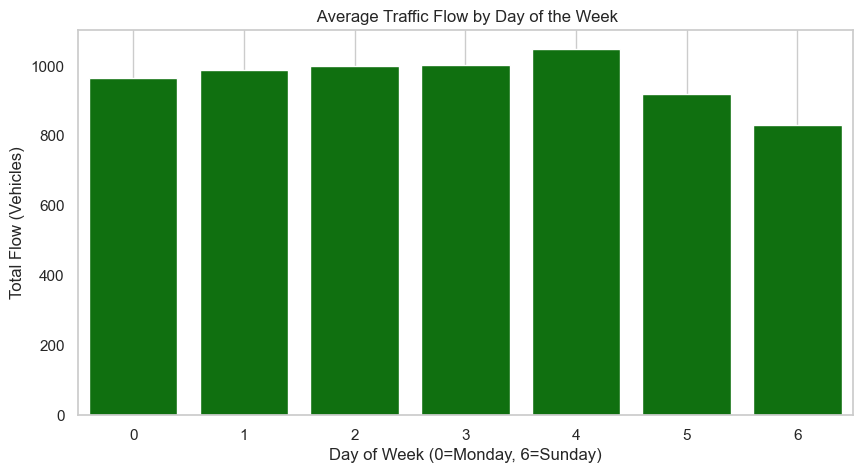

In [106]:
# Group by Day of Week
weekday_flow = df.groupby('Day_of_Week')['Total Flow'].mean()

plt.figure(figsize=(10,5))
sns.barplot(x=weekday_flow.index, y=weekday_flow.values, color = "green")
plt.title(" Average Traffic Flow by Day of the Week")
plt.xlabel("Day of Week (0=Monday, 6=Sunday)")
plt.ylabel("Total Flow (Vehicles)")
plt.grid()
plt.show()


Interpretation:
Weekdays (Monday - Friday) have higher traffic volumes, peaking on Friday.
Traffic drops on weekends, especially on Sundays.
Work-week trends are clear, confirming a strong weekday commuting pattern.
Weekend traffic is lower, suggesting different mobility patterns.